# Implementation de l'active learning

In [34]:
import pandas as pd
import numpy as np
from joblib import load
from preprocessor import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from joblib import load

## Masquage des labels

In [35]:
# Chargement des donnees
data = pd.read_csv('/home/onyxia/work/PROJET_STATAPP/Data/Cleans/Data_for_active_learning.csv')
data.head(2)

,Unnamed: 0,Make,AccidentArea,Sex,MaritalStatus,Age,Fault,PolicyType,VehiclePrice,FraudFound_P,...,Days_Policy_Accident,PastNumberOfClaims,AgeOfVehicle,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,delay_weeks
0,0,Honda,Urban,Female,Single,21,Policy Holder,Sport - Liability,more than 69000,0,...,more than 30,none,3 years,No,No,External,none,1 year,3 to 4,1
1,1,Honda,Urban,Male,Single,34,Policy Holder,Sport - Collision,more than 69000,0,...,more than 30,none,6 years,Yes,No,External,none,no change,1 vehicle,61


In [36]:
#Données non labelisees et des labels
X = data.drop(columns=['FraudFound_P'])
y = data['FraudFound_P']
X.head(3)

,Unnamed: 0,Make,AccidentArea,Sex,MaritalStatus,Age,Fault,PolicyType,VehiclePrice,Deductible,...,Days_Policy_Accident,PastNumberOfClaims,AgeOfVehicle,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,delay_weeks
0,0,Honda,Urban,Female,Single,21,Policy Holder,Sport - Liability,more than 69000,300,...,more than 30,none,3 years,No,No,External,none,1 year,3 to 4,1
1,1,Honda,Urban,Male,Single,34,Policy Holder,Sport - Collision,more than 69000,400,...,more than 30,none,6 years,Yes,No,External,none,no change,1 vehicle,61
2,2,Honda,Urban,Male,Married,47,Policy Holder,Sport - Collision,more than 69000,400,...,more than 30,1,7 years,No,No,External,none,no change,1 vehicle,2


In [37]:
# Chargement du pipeline
preprocessor = load("preprocessor.joblib")

In [38]:
all_cols = binary_cols + label_cols + freq_cols + ordinal_cols + scale_cols # definit dans preprocessor.py
X_preprocessed = preprocessor.fit_transform(X)
X_preprocessed = pd.DataFrame(X_preprocessed, columns=all_cols)
X_preprocessed.head(2)

,AccidentArea,Sex,Fault,PoliceReportFiled,WitnessPresent,AgentType,Make,MaritalStatus,PolicyType,VehiclePrice,Days_Policy_Accident,PastNumberOfClaims,AgeOfVehicle,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,DriverRating,Deductible,Age,delay_weeks
0,1.0,0.0,1.0,0.0,0.0,0.0,6.0,2.0,0.000065,5.0,4.0,0.0,2.0,0.0,2.0,2.0,1.0,300.0,-1.516574,-1.856357
1,1.0,1.0,1.0,1.0,0.0,0.0,6.0,2.0,0.022570,5.0,4.0,0.0,5.0,0.0,0.0,0.0,4.0,400.0,-0.489689,0.602140


In [39]:
len(X_preprocessed)

15419

## Séparation des donnees en 3 parties test/seed/pool

In [40]:
# 20% pour le test
X_pool_full, X_test, y_pool_full, y_test = train_test_split(
    X_preprocessed, y, test_size=0.2, stratify=y, random_state=42
)

# 2% d'observations initiales pour le seed dans le x_pool
X_init, X_pool, y_init, y_pool = train_test_split(
    X_pool_full, y_pool_full, train_size=0.02, stratify=y_pool_full, random_state=42
)

In [41]:
# Donnees pour la methode par uncertainty sampling US (on prends les memes) 

X_init_US = X_init
X_pool_US = X_pool
y_init_US = y_init
y_pool_US = y_pool

In [42]:
print ("Nombre de lignes du pool final : ",len(X_pool) ,
 "; Nombre de lignes du seed : ", len(X_init))


Nombre de lignes du pool final :  12089 ; Nombre de lignes du seed :  246


## Initialisation du modèle et SMOTE

In [43]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(
    learning_rate=0.05,
    max_depth=10,
    n_estimators=300,
    random_state=42
)
smote = SMOTE(sampling_strategy=0.25, random_state=42)


In [44]:
model_US = LGBMClassifier(
    learning_rate=0.05,
    max_depth=10,
    n_estimators=300,
    random_state=42
)

## Boucle de l'active learning

In [45]:
# Tracking des résultats
results = []
#________________________________ Boucle d'active learning________________________________#

while len(X_init) < 12089 and len(X_pool) > 0:

    # ---- SMOTE sur le init ----
    X_init_smote, y_init_smote = smote.fit_resample(X_init, y_init)
    X_init_US_smote, y_init_US_smote = smote.fit_resample(X_init_US, y_init_US)

    # ---- Entraînement ----
    model.fit(X_init_smote, y_init_smote)
    model_US.fit(X_init_US_smote, y_init_US_smote)

    # ---- ÉvUSuation sur le test set ----
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]

    y_test_US_pred = model_US.predict(X_test)
    y_test_US_proba = model_US.predict_proba(X_test)[:, 1]

    results.append({
        "labels_used": len(X_init),
        "accuracy_random_sampling": accuracy_score(y_test, y_test_pred),
        "f1_random_sampling": f1_score(y_test, y_test_pred),
        "recall_random_sampling": recall_score(y_test, y_test_pred),
        "precision_random_sampling": precision_score(y_test, y_test_pred),
        "auc_random_sampling": roc_auc_score(y_test, y_test_proba),
        "accuracy_uncertainty_sampling": accuracy_score(y_test, y_test_US_pred),
        "f1_uncertainty_sampling": f1_score(y_test, y_test_US_pred),
        "recall_uncertainty_sampling": recall_score(y_test, y_test_US_pred),
        "precision_uncertainty_sampling": precision_score(y_test, y_test_US_pred),
        "auc_uncertainty_sampling": roc_auc_score(y_test, y_test_US_proba)
    })

    # ---- Prédiction sur le pool ----
    y_pool_proba = model.predict_proba(X_pool)[:, 1]
    y_pool_US_proba = model_US.predict_proba(X_pool)[:, 1]

    #################################################################################
    # ---- Echantillonage aleatoire ----
    #################################################################################

    x_batch, X_pool_new, y_batch, y_pool_new = train_test_split(
    X_pool, y_pool, train_size = 50, stratify = y_pool, random_state=42)

    # ---- Ajout des points au init ----
    X_init = pd.concat([X_init, x_batch])
    y_init = pd.concat([y_init, y_batch])

    # ---- Suppression des points du pool ----
    X_pool = X_pool_new
    y_pool = y_pool_new

    ####################################################################################
    #--------- Uncertainty sampling----------------------------------------------------#
    ####################################################################################

    # ---- Calcul du seuil de Youden sur le init ----
    y_init_US_proba = model_US.predict_proba(X_init_US)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_init_US, y_init_US_proba)
    youden = tpr - fpr
    best_idx = np.argmax(youden)
    youden_threshold = thresholds[best_idx]

    # ---- Sélection des 50 observations les plus proches du seuil ----
    dist_to_threshold = np.abs(y_pool_US_proba - youden_threshold)
    n_select = min(50, len(X_pool))  # sécurité si pool < 50
    query_idx = np.argsort(dist_to_threshold)[:n_select]

    # ---- Ajout des points au init ----
    X_new = X_pool_US.iloc[query_idx]
    y_new = y_pool_US.iloc[query_idx]
    X_init_US = pd.concat([X_init_US, X_new])
    y_init_US = pd.concat([y_init_US, y_new])

    # ---- Suppression des points du pool ----
    X_pool_US = X_pool_US.drop(X_pool_US.index[query_idx])
    y_pool_US = y_pool_US.drop(y_pool_US.index[query_idx])

    

# -----------------------
# Résultats finaux
# -----------------------
results_df = pd.DataFrame(results)
results_df


[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[LightGBM] [Info] Start training from score -1.399366
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


,labels_used,accuracy_random_sampling,f1_random_sampling,recall_random_sampling,precision_random_sampling,auc_random_sampling,accuracy_uncertainty_sampling,f1_uncertainty_sampling,recall_uncertainty_sampling,precision_uncertainty_sampling,auc_uncertainty_sampling
0,246,0.922827,0.084615,0.059459,0.146667,0.634654,0.922827,0.084615,0.059459,0.146667,0.634654
1,296,0.924449,0.114068,0.081081,0.192308,0.666624,0.933852,0.028571,0.016216,0.120000,0.575157
2,346,0.921530,0.129496,0.097297,0.193548,0.678644,0.933528,0.046512,0.027027,0.166667,0.572020
3,396,0.926070,0.095238,0.064865,0.179104,0.673787,0.932879,0.037209,0.021622,0.133333,0.663425
4,446,0.925097,0.101167,0.070270,0.180556,0.691897,0.934501,0.047170,0.027027,0.185185,0.682741
...,...,...,...,...,...,...,...,...,...,...,...
232,11846,0.939689,0.097087,0.054054,0.476190,0.813380,0.938392,0.077670,0.043243,0.380952,0.816917
233,11896,0.938716,0.086957,0.048649,0.409091,0.804937,0.939689,0.079208,0.043243,0.470588,0.815758
234,11946,0.939689,0.105769,0.059459,0.478261,0.813235,0.940337,0.106796,0.059459,0.523810,0.815571
235,11996,0.939364,0.087805,0.048649,0.450000,0.810602,0.939689,0.088235,0.048649,0.473684,0.815683


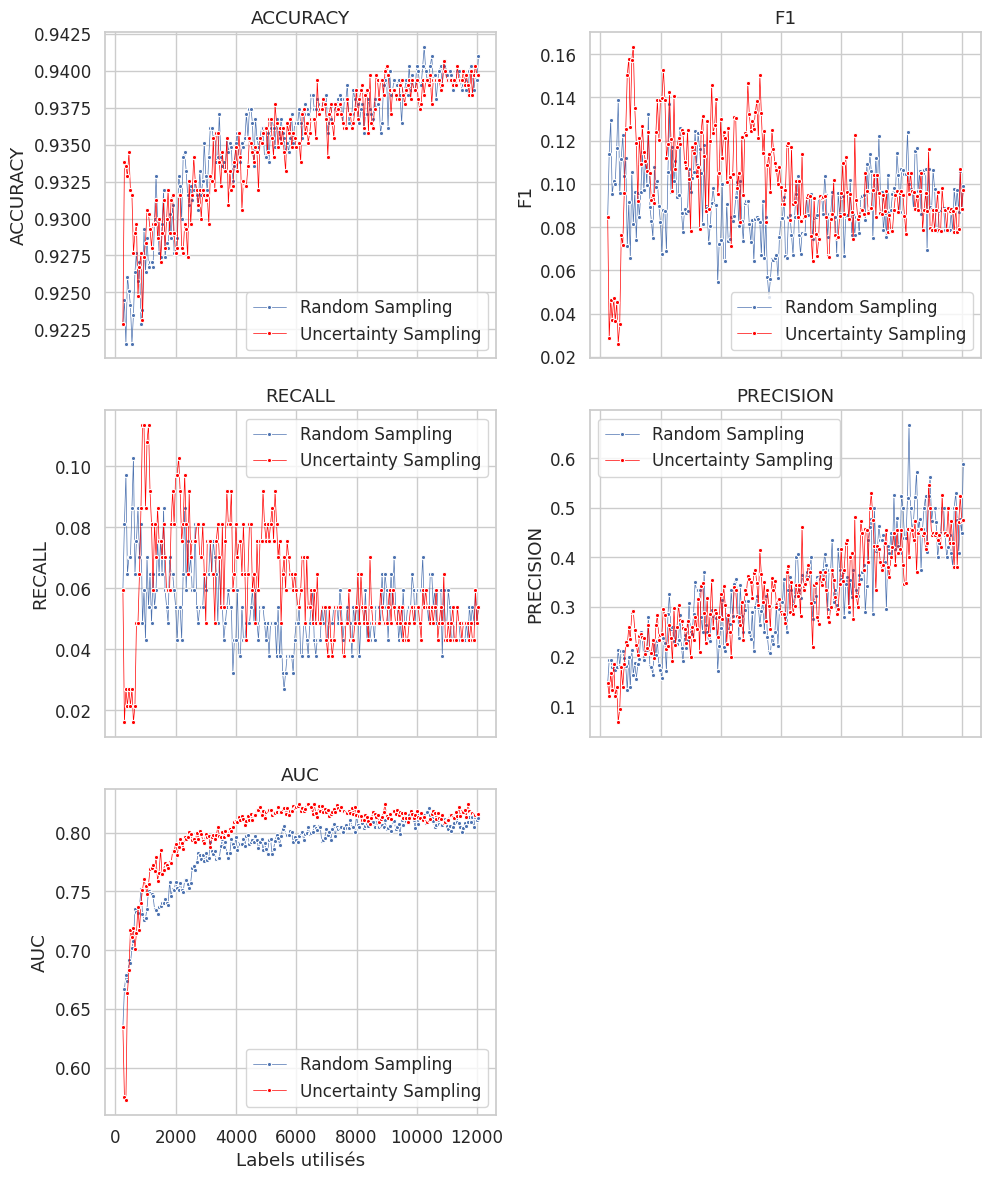

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

sns.set_theme(style="whitegrid", palette="deep", font_scale=1.1)

metrics = ["accuracy", "f1", "recall", "precision", "auc"]
n_metrics = len(metrics)

n_rows = 3
n_cols = math.ceil(n_metrics / n_rows)

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(5 * n_cols, 4 * n_rows),
    sharex=True
)

axes = axes.flatten()

for i, m in enumerate(metrics):
    ax = axes[i]

    sns.lineplot(
        x=results_df["labels_used"],
        y=results_df[f"{m}_random_sampling"],
        marker=".",
        linewidth=0.5,
        ax=ax,
        label="Random Sampling"
    )

    sns.lineplot(
        x=results_df["labels_used"],
        y=results_df[f"{m}_uncertainty_sampling"],
        marker=".",
        linewidth=0.5,
        ax=ax,
        label="Uncertainty Sampling",
        color = 'red'
    )

    ax.set_title(m.upper())
    ax.set_xlabel("Labels utilisés")
    ax.set_ylabel(m.upper())
    ax.legend()

# Supprimer les axes vides
for j in range(n_metrics, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
